### Look for Audio Pattern 

* **Objective**: is to find a pattern that is possible to find the openning of an episode of globo play.
* **Hypotheses**: applying some type of transformation in the singal and after applying the convolution, it is possible to notice the difference in the singal

> Install some packages that is needed to run this notebook

In [79]:
#!pip install librosa ffmpeg matplotlib

> Import all the requires library and put some configurations 

In [80]:
from IPython.core.display import display, HTML
from multiprocessing.dummy import Pool as ThreadPool 
from sklearn.cluster import KMeans
from scipy import signal, fft
import numpy as np
import os

import librosa
import matplotlib.pyplot as plt
import librosa.display
import worker

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


> List the samples inside the directory.

In [81]:
ls samples

8701320.mp3  8701320.wav  949809.mp3   949809.wav


> Convert the files inside the directory `./samples` from *mp3* to *wav*, because librosa works better with wav

In [82]:
files = os.listdir('./samples/')
files = list(filter(lambda x: '.mp3' in x, files))

pool = ThreadPool(4) 
pool.map(worker.from_mp3_to_wav, files)
pool.close() 
pool.join() 

[
    7957359,
    7957360,
    7957369,
    7976307
  ],

> Run Anlysitcs
* Plot similarity chart, to understand the signal.
* Plot similarity with only absolute values, without signal.
* Run low pass filter and than plot the signal.
* Perform a K-means on the signal and then check the labels of the entire signal, to check for discontinuity

In [83]:
def run_anlytics(similarities, intro_len):
    plt.figure(figsize=(19,19))
    # First Plot 
    plt.subplot(4,1,1)
    plt.title('Similaridade')
    plt.plot(similarities)
    # Second Plot
    plt.subplot(4,1,2)
    positive_similarities = abs(similarities)
    plt.title('Similaridade Absoluta')
    plt.plot(positive_similarities)
    # Third Plot 
    plt.subplot(4,1,3)
    pulse = signal.hann(intro_len) #np.ones(len(intro_x))
    filtered_signal = signal.convolve(positive_similarities, pulse, mode='same')
    plt.title('Similaridade com Filtro Passa Baixa')
    plt.plot(filtered_signal)
    plt.subplot(4,1,4)
    # Fourth Plot
    kmeans = KMeans(n_clusters=2, random_state=0).fit(filtered_signal.reshape(-1,1))
    kmeans.labels_
    plt.title('Label K-means')
    plt.plot(kmeans.labels_)
    plt.show()

> Apply Fast Forrier Transform to filter the signal and after apply convolution to check the similarity
* Convolve two N-dimensional arrays using FFT[Link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.fftconvolve.html)

In [84]:
def fft_approach(intro_x, episode_x, sr):
    intro_len = len(intro_x)
    similarities = signal.fftconvolve(episode_x, intro_x, mode='same')
    run_anlytics(similarities, intro_len)

> Apply mu-law to filter the signal and after apply convolution to check the similarity
* Given an input signal -1 <= x <= 1, the mu-law compression is calculated by: sign(x) * ln(1 + mu * abs(x)) /  ln(1 + mu) [Link](https://librosa.org/doc/latest/generated/librosa.mu_compress.html?highlight=law)

In [85]:
def mu_law_compression_approach(intro_x, episode_x, sr):
    intro_len = len(intro_x)
    mu_compress_episode = librosa.mu_compress(episode_x, quantize=False)
    mu_compress_intro = librosa.mu_compress(intro_x, quantize=False)
    similarities = signal.convolve(mu_compress_episode, mu_compress_intro, mode='same')
    run_anlytics(similarities, intro_len)

> Apply mu-law to filter the signal and after apply convolution to check the similarity
* This function is the inverse of mu_compress. Given a mu-law compressed signal -1 <= x <= 1, the mu-law expansion is calculated by: sign(x) * (1 / mu) * ((1 + mu)**abs(x) - 1) [Link](https://librosa.org/doc/latest/generated/librosa.mu_expand.html?highlight=law)

In [86]:
def mu_law_expansion_approach(intro_x, episode_x, sr):
    intro_len = len(intro_x)
    mu_expand_episode = librosa.mu_expand(episode_x , quantize=True)
    mu_expand_intro = librosa.mu_expand(intro_x,  quantize=True)
    similarities = signal.convolve(mu_expand_episode, mu_expand_intro, mode='same')
    run_anlytics(similarities, intro_len)

> Run the approaches over the intro and episode given, and after plotting the requires charts.

In [87]:
def audio_search(intro, episode):
    intro_file = './samples/{}'.format(intro)
    episode_file = './samples/{}'.format(episode)
    
    episode_x, episode_sr = librosa.load(episode_file, sr=44100)
    intro_x, intro_sr = librosa.load(intro_file, sr=44100)
    
    display(HTML('<h4>FTT</h4>'))
    fft_approach(intro_x, episode_x, episode_sr)
    display(HTML('<h4>Mu-Law Compression</h4>'))
    mu_law_compression_approach(intro_x, episode_x, episode_sr)
    display(HTML('<h4>Mu-Law Expansion</h4>'))
    mu_law_expansion_approach(intro_x, episode_x, episode_sr)

> Run the audio search analysis over the videos 8701320 `intro`and 949809 `first block`.

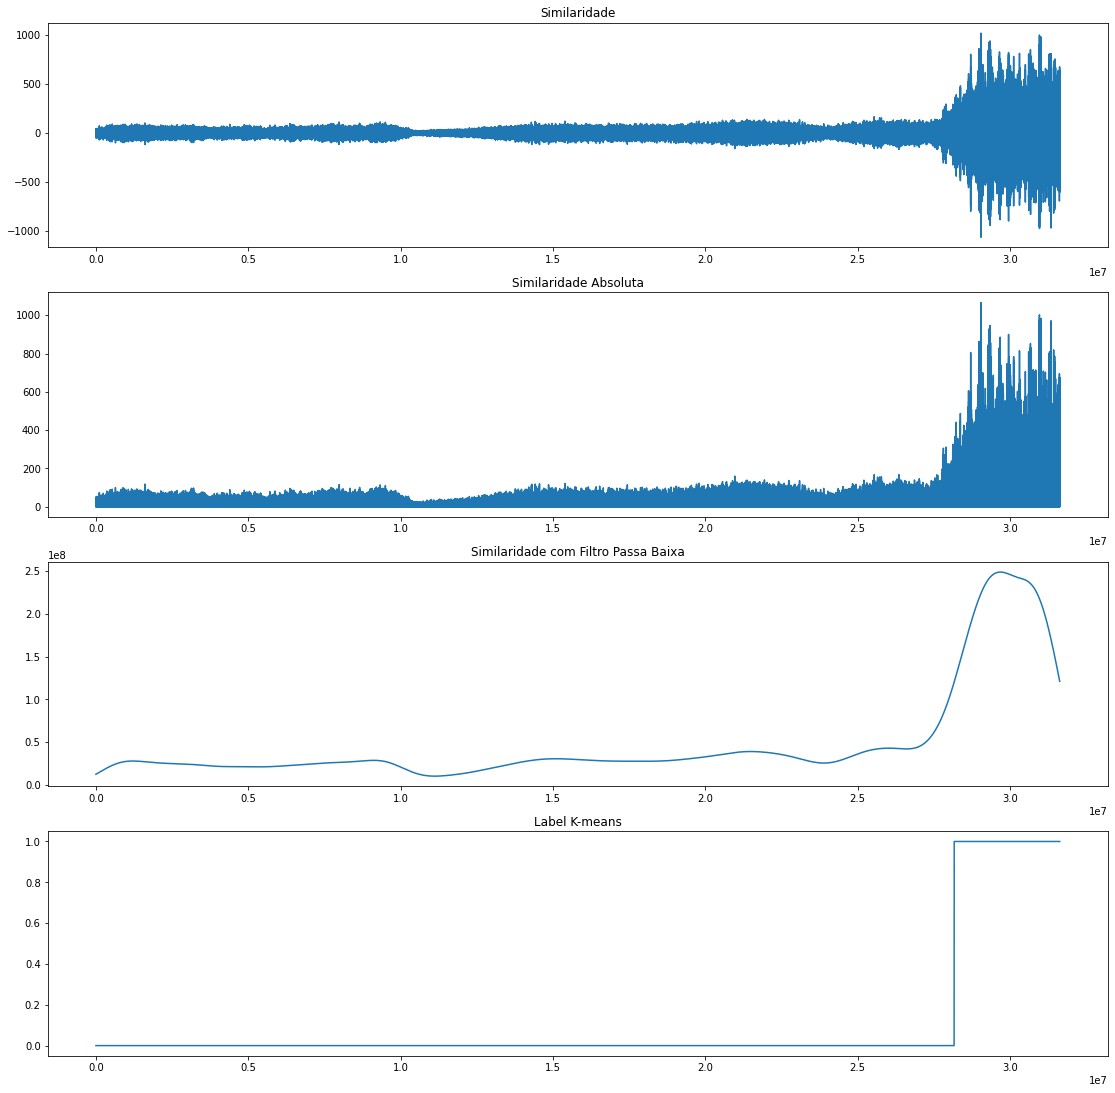

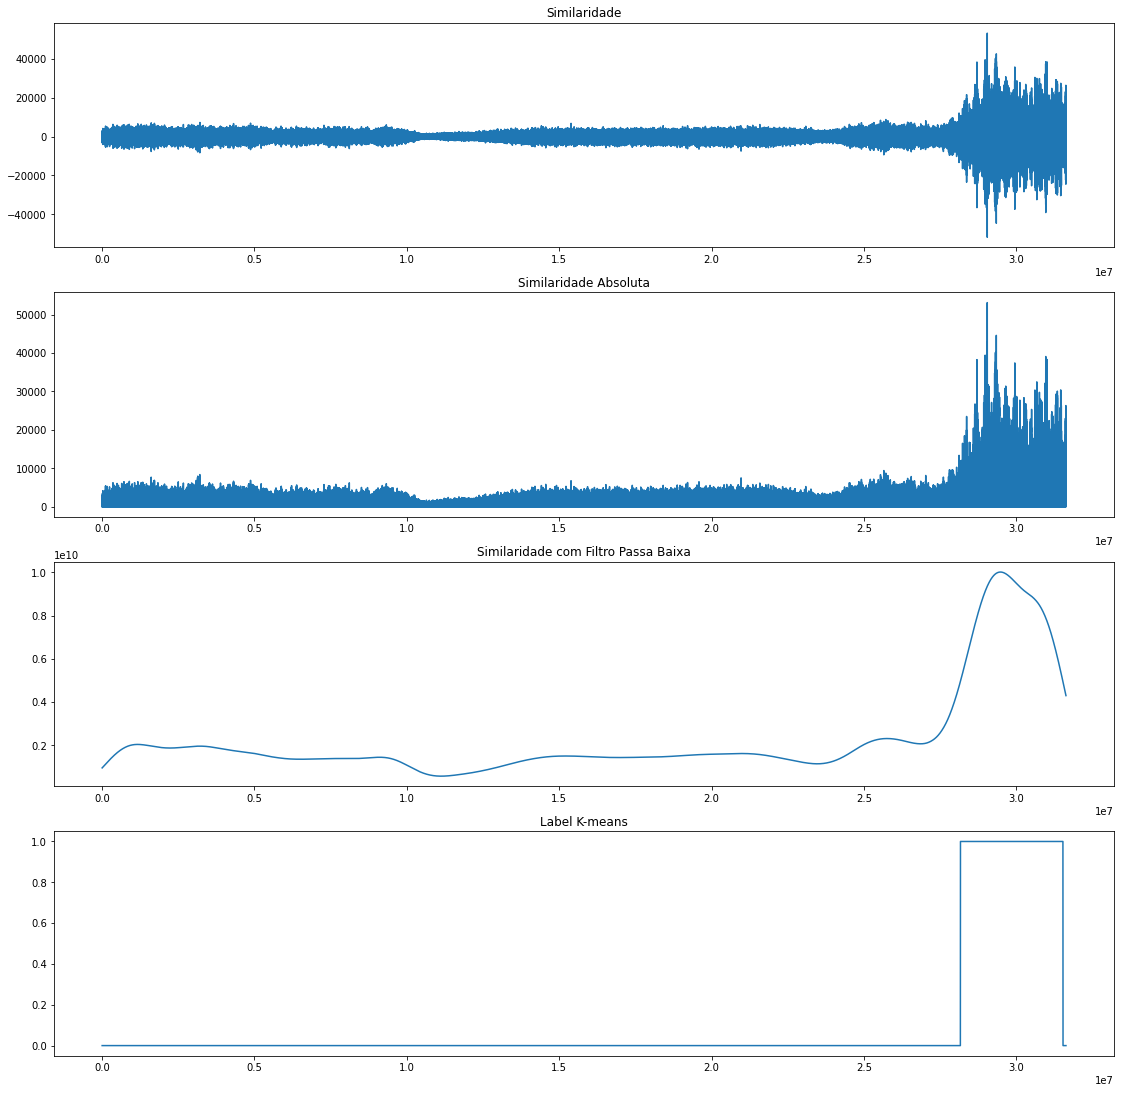

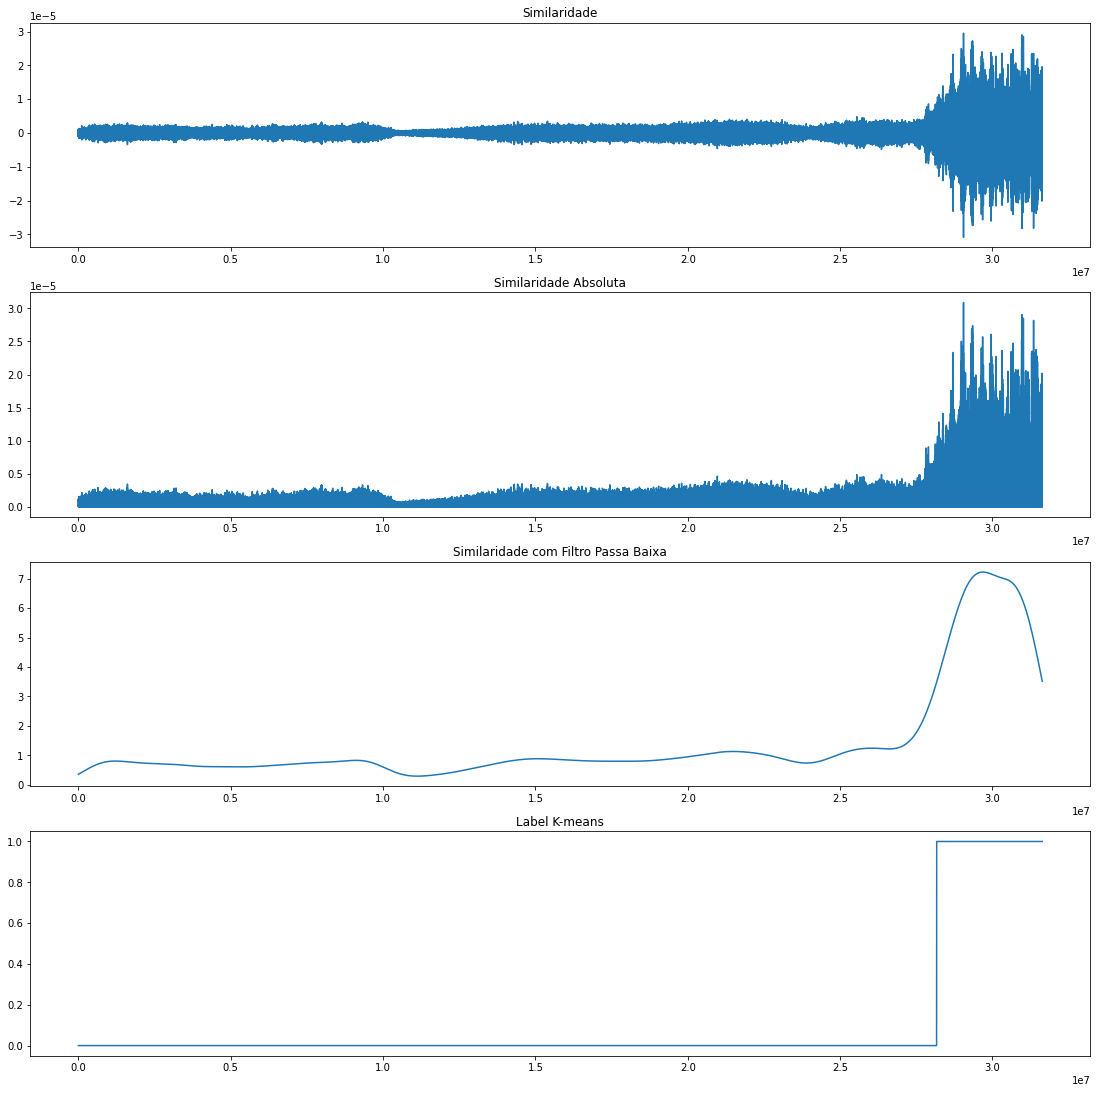

In [88]:
audio_search('8701320.wav', '949809.wav')